In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols, rlm
import statsmodels.stats.api as sms
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import numpy as np
import pandas as pd

import tabulate as tb
import Quandl as q
import scipy.stats as st

In [2]:
%matplotlib inline

# Caso 1.2.
# Estimación del impacto del dinero en una función Cobb-Douglas.

Hong V. Nguyen, en un artículo de 1986 en el Journal of Money, Credit and Banking titulado "Money in the aggregate Production Function: Reexamination and Further Evidence" evalúa el papel jugado por el dinero en la función agregada de producción. La idea de incluir el dinero como un input en la función agregada de producción fue inicialmente contrastada por Sinai y Stokes en 1972. Su conclusión básica para los Estados Unidos, usando datos anuales de 1929 a 1967, fue que la variable de tendencia clásica usada para medir cambios tecnológicos era de hecho una aproximación al dinero en la función de producción. Más argumentos para incluir el dinero como un input productivo en la función agregada de producción están basados en el hecho de que el dinero facilita los cambios, hace los mercados más eficientes y por lo tanto permite un mayor nivel de output. Para llevar a cabo su análisis, Nguyen especifica una función de producción Cobb- Douglas para la economía de USA (ec.1).

> $$Y = A · Lα · Kβ · Mg · e·θ·t · μ \ (1)$$ 

donde:

Y = Output interior privado

L = Servicios de trabajo

K = Servicios de capital

M = M1 ó M2 real

t = la tendencia en el tiempo

μ = término de error

En esta especificación, el dinero es tratado como un input regular y la tendencia es utilizada para capturar cambios tecnológicos.

TIPO DE DATOS: Serie temporal; 49 observaciones, 1930-1978. Fichero DINPROD.XLS.

## VARIABLES:

L = Servicios de trabajo en billones de dólares de 1972

K = Servicios de capital en billones de dólares de 1972

M1 = M1 oferta monetaria en billones de dólares corrientes

M2 = M2 oferta monetaria en billones de dólares corrientes

Y = Output real en billones de dólares de 1972

PY = Índice de precios implícitos de Y, 1972=100

>Alternativamente, los grupos pueden tomar los datos de la Base de datos AMECO de la Comisión Europea (periodicidad anual 1960-2016) y estimar alguna función de producción para algún país europeo. En este caso las cuestiones del ejercicio habría que hacerlas con la variable temporal, sin tener en cuenta la variable de oferta monetaria y añadiendo (voluntariamente) la variable educación.

> - L = Employment, persons: all domestic industries (National accounts) (NETD) 
> 
> - K = Net capital stock at 2010 prices: total economy (OKND)
> 
> - Y = Gross domestic product at 2010 reference levels (OVGD)
> 
> - EDU = A partir de la variable de consumo: Actual Individual Final Consumption of Households, 2010 constant prices (OCTH), euros. Para calcular de forma aproximada lo que se destina a educación, tomando como referencia un estudio del INE que calculó en 2008 que aproximadamente el 1’3% de los gastos de consumo familiares españoles se destinaba a educación, vamos a redondear al 2% para todos los países europeos. Calcular el 2% de estos valores en Excel antes de importarlos a Gretl. En esta variable hay observaciones ausentes al principio de la muestra para varios países.

> Los grupos pueden seleccionar los datos para alguno de los siguientes países: Bélgica, Dinamarca, Alemania (hay datos para Alemania del Este separados), Irlanda, Grecia, España, Francia, Italia, Luxemburgo, Holanda, Austria, Portugal, Finlandia, Suecia, Reino Unido, Noruega, Suiza, Estados Unidos y Japón.

# CUESTIONES:

## METODOLOGÍA

País Elegido: __Estados Unidos__

Datos con __frecuencia anual__

Datos obtenidos de Quandl.com (AMECO, ODA, FRED)

__VARIABLES:__
- Empleo [enlace](https://www.quandl.com/data/ODA/USA_LE)
- Stock de capital [enlace](https://www.quandl.com/data/AMECO/USA_1_0_0_0_OKND)
- PIB [enlace](https://www.quandl.com/data/ODA/USA_NGDP_R)
- Deflactor del PIB [enlace](https://www.quandl.com/data/ODA/USA_NGDP_D)
- M1 [enlace](https://www.quandl.com/data/FRED/MYAGM1USM052N)

In [3]:
# variables estados unidos frecuencia anual
at = "FEYg7kN2xEu3Rmi-gA1m"

l = q.get("ODA/USA_LE", authtoken=at)                              # empleo
k = q.get("AMECO/USA_1_0_0_0_OKND", authtoken=at)                  # capital
py = q.get("ODA/USA_NGDP_D", authtoken=at)                         # deflactor del pib
y = q.get("ODA/USA_NGDP_R", authtoken=at)                          # pib
m = q.get("FRED/MYAGM1USM052N", authtoken=at, collapse='annual')   # oferta monetaria

In [6]:
data = pd.concat([y,l,k,m, py], axis=1, join='inner')
data.columns = ['y', 'l', 'k', 'm', 'py']
print(data.head())

                   y        l         k             m      py
1980-12-31  6450.400   99.303  16734.02  4.200000e+11  44.377
1981-12-31  6617.750  100.400  17156.18  4.470000e+11  48.520
1982-12-31  6491.275   99.529  17485.36  4.860000e+11  51.531
1983-12-31  6792.000  100.822  17864.91  5.330000e+11  53.565
1984-12-31  7285.025  105.003  18387.23  5.650000e+11  55.466


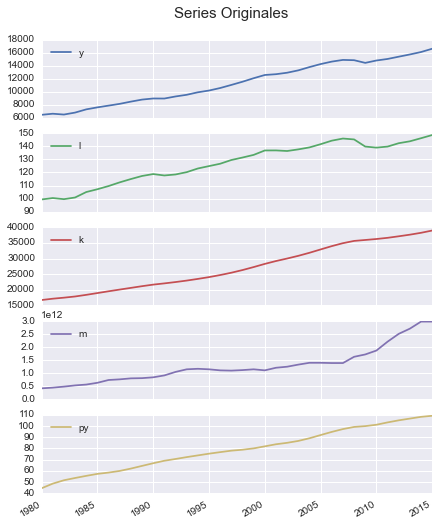

In [5]:
data.plot(subplots=True, layout=(5,1), figsize=(7, 9))
plt.suptitle('Series Originales', fontsize=15, y=.95)

/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/seaborn/linearmodels.py:1283: UserWarning: The `corrplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `corrplot` function has been deprecated in favor "
/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/seaborn/linearmodels.py:1349: UserWarning: The `symmatplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `symmatplot` function has been deprecated in favor "


/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


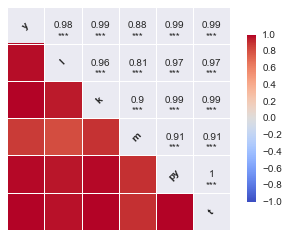

In [47]:
sns.corrplot(data)

/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


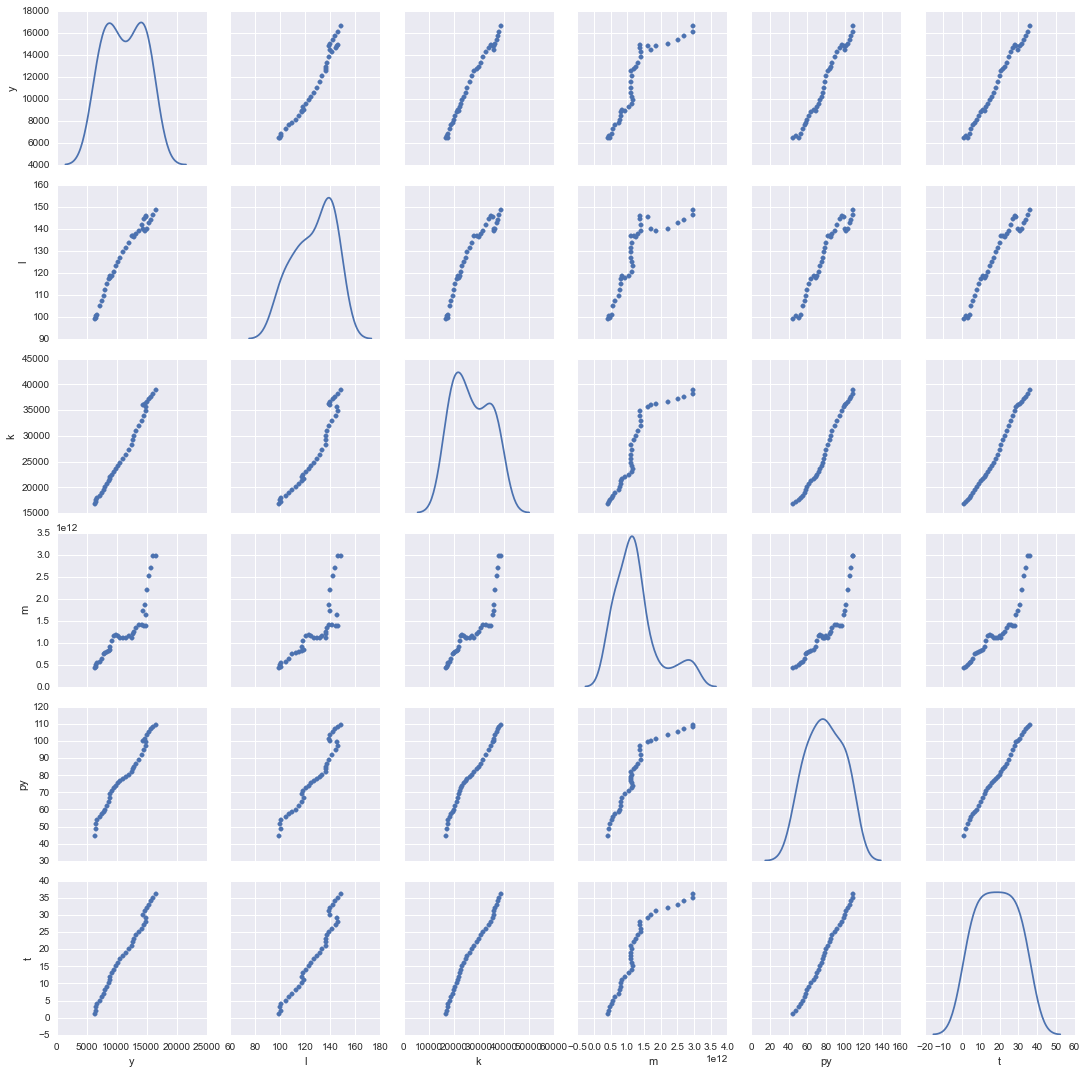

In [51]:
sns.pairplot(data, diag_kind='kde')

# APARTADO A

Para estimar la ecuación 1 usando la muestra de período 1930 a 1978, la ecuación tiene que ser transformada en un modelo que sea lineal en los parámetros. Este modelo transformado viene dado en la ecuación 2.

> $$log(Y_t) = λ + α· log( L_t) + β· log( K_t ) + g· log(m_t) + θ_t + u_t\ (2)$$

donde:

Y, L, y K han sido definidas

m= dinero real, siendo igual a M1/PY o M2/PY

$u_t = log(μ_t)$. 

Los grupos tipo A usarán M1 y los grupos B usarán M2.

In [7]:
# añadir tendencia temporal
data['t'] = np.arange(1, len(data) + 1)

print(data.head())

                   y        l         k             m      py  t
1980-12-31  6450.400   99.303  16734.02  4.200000e+11  44.377  1
1981-12-31  6617.750  100.400  17156.18  4.470000e+11  48.520  2
1982-12-31  6491.275   99.529  17485.36  4.860000e+11  51.531  3
1983-12-31  6792.000  100.822  17864.91  5.330000e+11  53.565  4
1984-12-31  7285.025  105.003  18387.23  5.650000e+11  55.466  5


## APARTADO A1

Utilizando los datos suministrados y la definición M1 (o M2) de dinero real, estimar la ecuación 2 por Mínimos Cuadrados Ordinarios (MCO). A lo largo de este ejercicio hay que interpretar económicamente cada modelo que se estime, respecto de los contrastes residuales, hay que hacerlos y tenerlos guardados para la tabla-resumen final, pero no hay que poner los contrastes después de cada modelo.

In [8]:
formula = 'np.log(y) ~ np.log(l) + np.log(k) + np.log(m/py) + t'
reg_a = ols(formula, data).fit().get_robustcov_results(cov_type='HC1')
print(reg_a.summary())

                            OLS Regression Results                            
Dep. Variable:              np.log(y)   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.107e+04
Date:                Mon, 02 Nov 2015   Prob (F-statistic):           2.06e-48
Time:                        18:57:53   Log-Likelihood:                 116.13
No. Observations:                  36   AIC:                            -222.3
Df Residuals:                      31   BIC:                            -214.3
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          1.3503      1.803      0.

## APARTADO A2
Contrastar la significatividad individual y conjunta de las variables independientes mediante los respectivos tests t-Student y F de Snedecor.

In [9]:
np.set_printoptions(precision=4)
bstr = r'\beta_%s:'

print('pvalues')
for i, p in enumerate(reg_a.pvalues):
    if p < 0.01:
        print(bstr % i, p, '***')
    elif p < 0.05:
        print(bstr % i, p, '**')
    else:
        print(bstr % i, p)

pvalues
\beta_0: 0.459491817285
\beta_1: 2.56907184673e-18 ***
\beta_2: 0.0541210563084
\beta_3: 0.195625840903
\beta_4: 0.0533817612494


In [10]:
fstr = 'F: %s\tpvalue: %s'
print(fstr % (reg_a.fvalue[0][0], reg_a.f_pvalue))

F: 11067.378293	pvalue: 2.060482280472647e-48


## APARTADO A3 
Contrastar a un nivel de significación del 5% la hipótesis nula:

$g = θ = 0$

In [11]:
r = [0,0,0,1,1]
ft = reg_a.f_test(r)
print(fstr % (ft.fvalue[0][0], ft.pvalue))

F: 1.25924751951	pvalue: 0.27041036115242006


# APARTADO B
Algunos economistas argumentan que si se ha especificado la función de producción correctamente y se han incluido todos los inputs relevantes, entonces debe mostrar rendimientos constantes de escala. Supongamos que el dinero real es de hecho un input en la función agregada de producción y que la tendencia no entra en la función de producción (ec. 3).

>$$log(Y_t) = λ + α · log( L_t) + β · log( K_t ) + g · log(m_t)  + u_t \ (3)$$

Para que la función de producción exhiba rendimientos constantes de escala, debe cumplirse que

$$α + β + g = 1$$

Imponiendo esta condición sobre el modelo de la ecuación 3 nos da el modelo restringido de la ecuación 4 (demostrar cómo se llega a esta ecuación).

>$$log(Y_t / K_t ) = λ + α ·log(L_t / K_t ) + g ·log(m_t / K_t) + u_t \ (4)$$

## APARTADO B1
Estimar las ecuaciones 3 y 4 usando los datos desde 1930 hasta 1978 y la definición de M1 (o M2) de dinero real. Contrastar la hipótesis de rendimientos constantes de escala a partir de las sumas de cuadrados de los residuos (SR) obtenidas en los dos modelos. Usar el contraste de Wald:


$F=\frac{\left(\frac{SR_R - SR}{m}\right)}{\left(\frac{SR}{n - k}\right)} \ ;\ (K = 4, m = 1)$

__Donde:__

- $RSS_0$ se refiere al coeficiente de determinación del modelo sin restringir $(R^2)$
- $RSS_1$ se refiere al coeficiente de determinación del modelo restringido $(R^2)$
- $m$ se refiere al número de restricciones impuestas a los coeficientes estimados (coficientes restringidos).
- $k$ se refiere al número de coeficientes estimados en el modelo sin restricciones.
- $n$ se refiere al número de observaciones del modelo.

$H_0$: Se Cumple la resticción


In [12]:
formula_3 = 'np.log(y) ~ np.log(l) + np.log(k) + np.log(m/py)'
reg_b1 = ols(formula_3, data).fit().get_robustcov_results(cov_type='HC1')

print(reg_b1.summary())

                            OLS Regression Results                            
Dep. Variable:              np.log(y)   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.225e+04
Date:                Mon, 02 Nov 2015   Prob (F-statistic):           4.97e-49
Time:                        18:57:56   Log-Likelihood:                 114.21
No. Observations:                  36   AIC:                            -220.4
Df Residuals:                      32   BIC:                            -214.1
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept         -2.2798      0.157    -14.

In [13]:
# Ecuación 4
formula_4 = 'np.log(y/k) ~ np.log(l/k) + np.log(m/(py * k))'
reg_b1_4 = ols(formula_4, data).fit().get_robustcov_results(cov_type='HC1')

print(reg_b1_4.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(y / k)   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     5.040
Date:                Mon, 02 Nov 2015   Prob (F-statistic):             0.0123
Time:                        18:57:56   Log-Likelihood:                 67.016
No. Observations:                  36   AIC:                            -128.0
Df Residuals:                      33   BIC:                            -123.3
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept               -0.9926 

In [14]:
h0_rdto = 'np.log(l) + np.log(k) + np.log(m / py) = 1'
ft = reg_b1.f_test(h0_rdto)

print(fstr % (ft.fvalue[0][0], ft.pvalue))

F: 410.893568712	pvalue: 7.996093625280387e-20


In [15]:
rss0 = reg_b1.ssr    # suma residual del modelo sin restringir
rss1 = reg_b1_4.ssr  # suma residual del modelo restringido

n = len(data)   # numero de observaciones
k = 4           # numero de coeficientes estimados en el modelo sin restringir
r = 3           # restricciones impuestas

ftest = ((rss1 - rss0) / (k-r)) / ((rss0) / (n-k))
ft = st.f.ppf(1-0.05, k-r, n-k)
names = ['SRR', 'SR', 'n', 'k', 'r', 'F-test', 'F-score']
values = [rss0, rss1, n, k, r, ftest, ft]

for i, n in enumerate(names):
    print(n,'= %s' % values[i])


SRR = 0.00369928539575
SR = 0.0509215980115
n = 36
k = 4
r = 3
F-test = 408.488084061
F-score = 4.1490974457


In [16]:
ftest ** 0.5

20.211088146384235

Para demostrar como pasar de la ecuación 3:

>$$log(Y_t) = λ + α · log( L_t) + β · log( K_t ) + g · log(m_t)  + u_t \ (3)$$

a la ecuación 4:

>$$log(Y_t / K_t ) = λ + α ·log(L_t / K_t ) + g ·log(m_t / K_t) + u_t \ (4)$$

Partimos de la restricción:

$\alpha + \beta + g = 1$

Despejamos $\beta$:

$\beta=1-\alpha-g$

Sustituimos $\beta$ en la ecuación 3:

$log(Y_t) = λ + α · log( L_t) + (1-\alpha-g) · log( K_t ) + g · log(m_t)  + u_t \ (3)$
$log(Y_t) = λ + α · log( L_t) + log( K_t ) - \alpha· log( K_t ) -g · log( K_t ) + g · log(m_t)  + u_t$
$log(Y_t) - log( K_t ) = λ + α · (log( L_t) - log( K_t )) + g · (log(m_t)-log( K_t ))  + u_t$
>$$log(Y_t / K_t ) = λ + α ·log(L_t / K_t ) + g ·log(m_t / K_t) + u_t \ (4)$$

## APARTADO B2
Bajo la hipótesis de rendimientos constantes a escala (modelo 4) se puede despejar una estimación del parámetro β. Encontrar tal estimación y construir un intervalo de confianza del 95% para el mismo.

Dada la restricción:

$$\alpha+\beta+g = 1$$
$$\hat{\alpha}+\hat{\beta}+\hat{g}=1$$
$$\hat{\beta}=1-\hat{\alpha}-\hat{g}$$

Sustituyendo las estimaciónes de $\alpha$ y $g$ tendremos la estimación de $\beta$.

In [17]:
alfa_est, beta_est, g_est = reg_b1_4.params
beta_est = 1 - alfa_est - g_est

print(r'\hat{\beta} =', beta_est)

\hat{\beta} = 2.03078397087


Para calcular el intervalo de confianza al 95%, necesitamos la varianza de $\hat{\beta}$:

$$V(\hat{\beta})=V(1-\hat{\alpha}-\hat{g})$$
$$V(\hat{\beta})=V(\hat{\alpha}) + V(\hat{g}) + 2Cov(\hat{\alpha}, \hat{g}))$$

In [18]:
var_a, var_b, var_g = reg_b1_4.bse

In [19]:
reg_b1_4.cov_params()

array([[ 0.2822,  0.0151, -0.0151],
       [ 0.0151,  0.002 , -0.0003],
       [-0.0151, -0.0003,  0.001 ]])

In [20]:
cov_ag = reg_b1_4.cov_params()[-1][1]

In [21]:
var_best = var_a + var_g + 2 * cov_ag
print(var_best)

0.562167288211


Intervalo de Confianza:

$$IC(\hat{\beta})=\hat{\beta} \pm Z_{\alpha/2}\sqrt{\frac{V(\hat{\beta})}{N}} $$

In [22]:
alpha = 0.05
z = st.norm.ppf(alpha/2)
ee = z * np.sqrt(var_best / len(data))

print('IC:',beta_est + ee, beta_est - ee)

IC: 1.78586093942 2.27570700232


## APARTADO B3
Dado el intervalo de confianza construido en el apartado b2), ¿es la estimación de β económica y estadísticamente significativa?

Es fácil comprobar que no es estadísticamente significativa, ya que la estimación de $\beta$ no esta contenida en el intervalo hallado, con una confianza del 95%.

## APARTADO B4

Dado que los __rendimientos constantes__ a escala implican sólo una restricción lineal sobre el modelo, se podría haber realizado un __test t__ para contrastar tal hipótesis. 

Usando las estimaciones de __α, β, y g__ de la __ecuación 3__, llevar a cabo tal test con un nivel de significación del 5%. 

Dado que los rendimientos constantes a escala implican sólo una restricción lineal sobre el modelo, se podría haber realizado un test t para contrastar tal hipótesis. 

Usando las estimaciones de α, β, y g de la ecuación 3 y definiendo un parámetro auxiliar $δ = α + β + g – 1$, llevar a cabo tal test sobre $δ$ con un nivel de significación del 5%. 

Para ello necesitaremos calcular la estimación de $δ$ a partir de las estimaciones de $α$, $β$ y $g$, y después la varianza estimada de $δ$, que es:

$V(δ) = V({\alpha}) + V({β}) +  V({g}) + 2·Cov(α, β) + 2·Cov( α, g) + 2·Cov({β, g})$

Y ahora ya podemos calcular el estadístico de contraste, que vendrá dado por:

$t(δ) = \frac{\delta}{V(δ)}$

el cual se distribuye bajo la hipótesis nula según una t-Student con T-4 grados de libertad.

b4:

$F = t^2$

> $$log(Y_t) = λ + α· log( L_t) + β· log( K_t ) + g· log(m_t) + θ_t + u_t\ (2)$$

> $$log(Y_t) = λ + α · log( L_t) + β · log( K_t ) + g · log(m_t)  + u_t \ (3)$$

In [23]:
reg_b1.params                 # parametros

array([-2.2798,  1.0905,  0.5849,  0.0149])

In [24]:
_[1:]                         # todos los parámetros menos el primero

array([ 1.0905,  0.5849,  0.0149])

In [25]:
delta = _.sum() - 1           # delta es la suma de los parametros - 1
delta

0.69029524484438065

In [26]:
reg_b1.cov_params()     # matriz de varianzas y covarianzas.

array([[ 0.0248, -0.0039,  0.0034, -0.0017],
       [-0.0039,  0.0037, -0.0019,  0.0002],
       [ 0.0034, -0.0019,  0.0012, -0.0003],
       [-0.0017,  0.0002, -0.0003,  0.0001]])

In [27]:
_.diagonal()                  # las varianzas estan en la diagonal de la matriz de var cov.

array([ 0.0248,  0.0037,  0.0012,  0.0001])

In [28]:
_[1:]                         # todas menos la primera 

array([ 0.0037,  0.0012,  0.0001])

In [29]:
var = _                       # varianzas

In [30]:
cov = list()                  # guardar covarianzas
for e in range(2):
    e += 1
    for ee in range(e,4-1):   
        cov.append(reg_b1.cov_HC1[e][ee+1])

In [31]:
var.flatten().sum()           # suma de varianzas

0.0049725129019827351

In [32]:
_ + 2 * sum(cov)                 # var + 2 veces la suma de covarianzas

0.0011596860144315615

In [33]:
v_delta = _                  # varianza de delta

In [34]:
s_delta = v_delta ** 0.5     # desviación tipica de delta

In [35]:
print(r'S(\delta) = %s' % s_delta )

S(\delta) = 0.034054162953


In [36]:
t_delta = delta / s_delta
print(r't(\delta) = %s' % t_delta)

t(\delta) = 20.2705098286


## APARTADO B5
¿Cuál es la relación entre el test F realizado en el apartado b1) y el test-t llevado a cabo en el apartado b4)?

El F-test es el el cuadrado del t-test.
Se cumple pues que $20.27 ^ 2 ≈ 408.48 (410.87)$

# APARTADO C
Nguyen, después de rechazar la idea de que el dinero era un input en la función de producción, propuso un papel alternativo para el dinero en el proceso productivo, y sugirió que era un "facilitador" del cambio tecnológico. Reformuló el modelo presentado en la ecuación 1 haciendo el coeficiente de tendencia, θ, una función de la tasa de crecimiento del dinero:

> $$\theta = \delta + \tau \frac{(M_t - M_{t-1})}{M_{t-1}}\ ,\ (5)$$ 

En esta formulación, la tasa de crecimiento de la productividad está descompuesta en dos partes: la que es debida al cambio técnico, medida a través del parámetro δ, y la que es debida a la interacción entre la tasa de crecimiento de saldos en efectivos reales, y el cambio técnico medido a través del parámetro τ. 

Es decir, hizo la hipótesis de que θ, el coeficiente de tendencia en el modelo básico (ecuación 1), era una función de la tasa de crecimiento de dinero real (ver la ecuación 5). Sustituyendo la ecuación 5 en la ecuación 1 se obtiene la siguiente ecuación como modelo básico.

> $$log(Y_t) = λ + α ·log( L_t) + β ·log( K_t ) + g· log(m_t) + δ · t + w (t·m_t^*) + u_t\ , \ (6)$$ 

donde $m_t^*$ es la tasa de cambio de la oferta monetaria real.

## APARTADO c1
Usando la tasa de crecimiento de la oferta monetaria real (o su aproximación como $m_t^* = log(m_t) - log(m_{t-1})$, estimar la ecuación 6 por MCO.

In [37]:
data_c = data.copy()
data_c['dm'] = data_c.m.pct_change()
data_c.dropna(axis=0, inplace=True)

formula_6 = 'np.log(y) ~ np.log(l) + np.log(k) + np.log(m/py) + t + np.multiply(t,dm)'
reg_c = ols(formula_6, data_c).fit().get_robustcov_results()
print(reg_c.summary())

                            OLS Regression Results                            
Dep. Variable:              np.log(y)   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     7212.
Date:                Mon, 02 Nov 2015   Prob (F-statistic):           6.23e-44
Time:                        18:58:32   Log-Likelihood:                 112.76
No. Observations:                  35   AIC:                            -213.5
Df Residuals:                      29   BIC:                            -204.2
Df Model:                           5                                         
Covariance Type:                  HC1                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept              1.3357      1

## APARTADO c2
Contrastar la significación conjunta de las variables a un nivel ε=0’01. 

In [38]:
fscore = st.f.ppf(1-0.01, reg_c.nobs-len(reg_c.params), 1)
fvalue = reg_c.fvalue
print('%s > %s' % (fscore, fvalue[0][0]))

6257.05302102 > 7212.01941491


F-score > F-test: Para un nivel de signifiación del 0.01 estamos en la región crítica y por tanto tenemos evidencia en contra de la hipótesis nula. Los parámetros son significativos.

¿Qué opina sobre los resultados obtenidos de la regresión? Hacer una tabla-resumen de los modelos (2), (3) y (6) estimados en el ejercicio, en la que aparezcan los contrastes RESET de especificación, de normalidad, LM(1) y LM(2) de autocorrelación y ARCH(1), junto con el R2 corregido y el criterio de Schwarz (SBIC).

In [45]:

names = ['ec2', 'ec3', 'ec6']
fs = [formula, formula_3, formula_6]
temp = '|%s|%s|%s|'
head = '|:---:|:---:|:---:|'
for i, m in enumerate([reg_a,reg_b1,reg_c]):
    
    print('|%s|VALOR| PVALOR |' % names[i].upper())
    print(head)
    if i == 2:
        d = data_c.copy()
    else:
        d = data.copy()

    d['y_hat2'] = m.predict() ** 2
    d['y_hat3'] = m.predict() ** 3

    reset = fs[i] + ' + y_hat2 + y_hat3'
    
    res = ols(reset, d).fit().get_robustcov_results()

    h0 = 'y_hat2 = y_hat3 = 0'

    test = res.f_test(h0)
    pv = np.round(test.pvalue, 4)

    print(temp % ('RESET', np.round(test.fvalue[0][0], 4), pv))
    print(temp % ('JB', sms.jarque_bera(m.resid)[0], sms.jarque_bera(m.resid)[1]))
    print(temp % ('BG(1)', sms.acorr_breush_godfrey(m, nlags=1)[0], sms.acorr_breush_godfrey(m, nlags=1)[1]))
    print(temp % ('BG(2)', sms.acorr_breush_godfrey(m, nlags=2)[0], sms.acorr_breush_godfrey(m, nlags=2)[1]))
    print(temp % ('ARCH(1)', sms.het_arch(m.resid, maxlag=1)[0], sms.het_arch(m.resid, maxlag=1)[1]))
    print('|%s|%s|' % (r'$\overline{R}^2$', m.rsquared_adj))
    print('|%s|%s|' % ('SBIC', m.bic))
    print()


|EC2|VALOR| PVALOR |
|:---:|:---:|:---:|
|RESET|2.8851|0.072|
|JB|1.5116026400135225|0.469634136681|
|BG(1)|11.0958269869|0.00086522191773|
|BG(2)|15.316729434|0.000472078762301|
|ARCH(1)|1.64993311385|0.198968034899|
|$\overline{R}^2$|0.998800414861|
|SBIC|-214.347148848|

|EC3|VALOR| PVALOR |
|:---:|:---:|:---:|
|RESET|3.9049|0.0311|
|JB|1.9374243991569333|0.379571535876|
|BG(1)|13.030579074|0.000306445778705|
|BG(2)|15.8351216851|0.000364289803896|
|ARCH(1)|4.16173757148|0.0413469675068|
|$\overline{R}^2$|0.99870725479|
|SBIC|-214.095193754|

|EC6|VALOR| PVALOR |
|:---:|:---:|:---:|
|RESET|1.9552|0.1611|
|JB|1.2634019490395654|0.531686645965|
|BG(1)|10.8408803732|0.00099283517457|
|BG(2)|13.4518743501|0.00119939600864|
|ARCH(1)|2.01057490311|0.156206114599|
|$\overline{R}^2$|0.998658631435|
|SBIC|-204.190031517|



|EC2|VALOR| PVALOR |
|:---:|:---:|:---:|
|RESET|2.8851|0.072|
|JB|1.5116026400135225|0.469634136681|
|BG(1)|11.0958269869|0.00086522191773|
|BG(2)|15.316729434|0.000472078762301|
|ARCH(1)|1.64993311385|0.198968034899|
|$\overline{R}^2$|0.998800414861|
|SBIC|-214.347148848|

|EC3|VALOR| PVALOR |
|:---:|:---:|:---:|
|RESET|3.9049|0.0311|
|JB|1.9374243991569333|0.379571535876|
|BG(1)|13.030579074|0.000306445778705|
|BG(2)|15.8351216851|0.000364289803896|
|ARCH(1)|4.16173757148|0.0413469675068|
|$\overline{R}^2$|0.99870725479|
|SBIC|-214.095193754|

|EC6|VALOR| PVALOR |
|:---:|:---:|:---:|
|RESET|1.9552|0.1611|
|JB|1.2634019490395654|0.531686645965|
|BG(1)|10.8408803732|0.00099283517457|
|BG(2)|13.4518743501|0.00119939600864|
|ARCH(1)|2.01057490311|0.156206114599|
|$\overline{R}^2$|0.998658631435|
|SBIC|-204.190031517|

¿Qué modelo se escogería de entre los tres?

A la vista de los datos, el mejor modelo sin duda, es el definido por la ecuación 6, dado que sólo adolece de autocorrelación, frente al resto que adolecen de una correcta especifiación y heterocedasticidad.